# Network analysis


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import qiskit
import glob
import os
from math import floor

import pydot
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
   

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile 
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit import visualization
from itertools import permutations
from qiskit_aer.noise import NoiseModel
import qiskit_aer
import qiskit_ibm_runtime
from qiskit_ibm_runtime import QiskitRuntimeService


from qiskit.transpiler import PassManager
sim = sim_qc_noise = qiskit_aer.AerSimulator()

token = os.environ["IBMQ_NU_API_KEY"] # CHANGE TO YOUR IBM ACCT KEY
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
qc = service.get_backend("ibm_brisbane")

In [2]:
backend_names = []
for i in service.backends():
    backend_names.append(str(i.name))

In [3]:

backends = {}
coupling_maps = {}
for item in backend_names:
    if 'simulator' not in item:
        backends[item] = service.get_backend(item)
        coupling_maps[item] = backends[item].configuration().coupling_map

In [4]:
brisbane_config = backends['ibm_brisbane'].configuration()

In [5]:
brisbane_config.online_date

datetime.datetime(2023, 1, 23, 5, 0, tzinfo=tzutc())

In [6]:
from qiskit.providers.fake_provider import FakeBackend
from qiskit.providers.models import BackendProperties, BackendConfiguration
from qiskit.providers.models.backendconfiguration import GateConfig


def build_grid_network_devices(length,width,qpu_count,chip_edge_weight):
    #return nx.grid_graph([length,width])
    n     = length*width
    devices = []
    for i in range(qpu_count):
        lower_bound = i*n
        upper_bound = (i+1)*n
        V     = np.arange(lower_bound,upper_bound,1)
        E     =[] 
        for j in range(lower_bound,upper_bound,1):
            temp_edges = []
            if (j%length)!= (length-1):
                temp_edges.append((j,j+1,chip_edge_weight))
            
            if (j%length)!= 0:
                temp_edges.append((j,j-1,chip_edge_weight))
                
            if (j-length) >= lower_bound:
                temp_edges.append((j,j-length,chip_edge_weight))
                
            if (j+length) < upper_bound:
                temp_edges.append((j,j+length,chip_edge_weight))
                
            for item in temp_edges:
                if (item not in E) or ((item[1],item[0],item[-1]) not in E):
                    E.append(item)

        G     = nx.Graph()
        G.add_nodes_from(V)
        G.add_weighted_edges_from(E)
        devices.append(G)
    
    return devices

def build_ring_network(length,width,qpu_count,chip_edge_weight,link_weight):
    chips = build_grid_network_devices(length,width,qpu_count,chip_edge_weight)
    n     = length*width
    conn1 = floor(length/2)
    conn2 = (n)-1-conn1
    
    print(conn1)
    print(conn2)
    
    ring_network = nx.Graph()
    for item in chips:
        ring_network.add_edges_from(item.edges())
        ring_network.add_nodes_from(item.nodes())
    
    for i in range(1,qpu_count):
        ring_network.add_edge((i-1)*n+conn2,i*n+conn1,weight=link_weight)
        if i == qpu_count-1:
            ring_network.add_edge((i)*n+conn2,conn1,weight=link_weight)
        
    
    return ring_network
    

def draw_graph(G):
    pos = nx.spring_layout(G)
    fig = plt.figure(figsize=(14, 14))
    nx.draw_networkx_nodes(G, pos,node_color='red', node_size=300)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    plt.show()
    
    
def graph_from_machine(n_qubits,c_map,add_weights = False, weight_value=1):
    G = nx.Graph()
    G.add_nodes_from(np.arange(n_qubits))
    G.add_edges_from(c_map)
    if add_weights == True:
        nx.set_edge_attributes(G, values = weight_value, name = 'weight')
    return G

def get_furthest_nodes(G):
    sp_length = {} # dict containing shortest path distances for each pair of nodes
    diameter = None # will contain the graphs diameter (length of longest shortest path)
    furthest_node_list = [] # will contain list of tuple of nodes with shortest path equal to diameter
    
    for node in G.nodes:
        # Get the shortest path from node to all other nodes
        sp_length[node] = nx.single_source_shortest_path_length(G,node)
        longest_path = max(sp_length[node].values()) # get length of furthest node from node
        
        # Update diameter when necessary (on first iteration and when we find a longer one)
        if diameter == None:
            diameter = longest_path # set the first diameter
            
        # update the list of tuples of furthest nodes if we have a best diameter
        if longest_path >= diameter:
            diameter = longest_path
            
            # a list of tuples containing
            # the current node and the nodes furthest from it
            node_longest_paths = [(node,other_node)
                                      for other_node in sp_length[node].keys()
                                      if sp_length[node][other_node] == longest_path]
            if longest_path > diameter:
                # This is better than the previous diameter
                # so replace the list of tuples of diameter nodes with this nodes
                # tuple of furthest nodes
                furthest_node_list = node_longest_paths
            else: # this is equal to the current diameter
                # add this nodes tuple of furthest nodes to the current list    
                furthest_node_list = furthest_node_list + node_longest_paths
                
    # return the diameter,
        # all pairs of nodes with shortest path length equal to the diameter
        # the dict of all-node shortest paths
    return({'diameter':diameter,
            'furthest_node_list':furthest_node_list,
            'node_shortest_path_dicts':sp_length})

def determine_diameter_path(G):
    node_info = get_furthest_nodes(G)
    diameter = node_info['diameter']
    for item in node_info['furthest_node_list']:
        if (len(nx.dijkstra_path(G,item[0],item[1]))-1) == diameter:
            return nx.dijkstra_path(G,item[0],item[1])
        

def sum_diam_path_weights(G,path):
    total = 0 
    for i in range(1,len(path)):
        total = total + G.get_edge_data(path[i],path[i-1])['weight']
        
    return total
    

In [7]:
class create_backend(FakeBackend):
    """create a backend with custom 2q gate error values.
    
        gate_error by default {}. add error with keys as 
        '[0, 1]', '[1, 0]', etc.
    
    """

    def __init__(self,coupling_map,name='custom_backend',gate_errors={}):
        
        self.gate_errors=gate_errors
        unique_qubits = list(set().union(*coupling_map))
        n_qubits = len(unique_qubits)

        configuration = BackendConfiguration(
            backend_name=name,
            backend_version='0.0.0',
            n_qubits=n_qubits,
            #basis_gates=['u1', 'u2', 'u3', 'cx', 'id'],
            basis_gates=['x', 'sx', 'rz', 'cx', 'id'],
            simulator=False,
            local=True,
            conditional=False,
            open_pulse=False,
            memory=False,
            max_shots=65536,
            gates=[GateConfig(name='TODO', parameters=[], qasm_def='TODO')],
            coupling_map=coupling_map,
        )

        super().__init__(configuration)
        

    def properties(self):
        """Return backend properties"""

        """Return backend properties"""

        coupling_map = self.configuration().coupling_map
        unique_qubits = list(set().union(*coupling_map))
        

        for pair in coupling_map:
            if str(pair) not in self.gate_errors:
                self.gate_errors[str(pair)] = 0.0

        properties = {
            #TODO: Add real values from machine when building up
            'backend_name': self.name(),
            'backend_version': self.configuration().backend_version,
            'last_update_date': '2000-01-01 00:00:00Z',
            'qubits': [
                [
                    {
                        "date": "2000-01-01 00:00:00Z",
                        "name": "T1",
                        "unit": "\u00b5s",
                        "value": 0.0
                    },
                    {
                        "date": "2000-01-01 00:00:00Z",
                        "name": "T2",
                        "unit": "\u00b5s",
                        "value": 0.0
                    },
                    {
                        "date": "2000-01-01 00:00:00Z",
                        "name": "frequency",
                        "unit": "GHz",
                        "value": 0.0
                    },
                    {
                        "date": "2000-01-01 00:00:00Z",
                        "name": "readout_error",
                        "unit": "",
                        "value": 0.0
                    }
                ] for _ in range(len(unique_qubits))
            ],
            'gates': [{
                "gate": "cx",
                "name": "CX" + str(pair[0]) + "_" + str(pair[1]),
                "parameters": [
                    {
                        "date": "2000-01-01 00:00:00Z",
                        "name": "gate_error",
                        "unit": "",
                        "value":  self.gate_errors[str(pair)]
                    }
                ],
                "qubits": [
                    pair[0],
                    pair[1]
                ]
            } for pair in coupling_map],
            'general': []
        }

        return BackendProperties.from_dict(properties)

    
def create_full_error_dict_cpu(coupling_map,avg_error,gate_errors={}):
    
    for pair in coupling_map:
        if str(pair) not in gate_errors:
            gate_errors[str(pair)] = avg_error
    return gate_errors


def create_square_network_map_27f(original_backend,edge_length):
    config = original_backend.configuration()
    coupling_map = config.coupling_map
    n_qubits = config.n_qubits
    new_coupling_map = []
    
    links = []
    h_link_pairs = [[23,0],[26,3]]
    v_link_pairs = [[9,6],[20,17]]
    
    for i in range(edge_length**2):
        for pair in coupling_map:
            temp = []
            temp.append(pair[0]+(i*n_qubits))
            temp.append(pair[1]+(i*n_qubits))
            new_coupling_map.append(temp)
            
            
        if i < edge_length**2-edge_length:
            #add bottom connection via links
            for pair in v_link_pairs:
                temp = []
                temp.append(pair[0]+(i*n_qubits))
                temp.append(pair[1]+(i+edge_length)*n_qubits)
                links.append(temp)
                
                temp = [] #include reverse direction
                temp.append(pair[1]+(i+edge_length)*n_qubits)
                temp.append(pair[0]+(i*n_qubits))
                links.append(temp)
                
        if i%edge_length != (edge_length-1):
            #right connection
            for pair in h_link_pairs:
                temp = []
                temp.append(pair[0]+(i*n_qubits))
                temp.append(pair[1]+((i+1)*n_qubits))
                links.append(temp)
                
                temp = [] #include reverse direction
                temp.append(pair[1]+((i+1)*n_qubits))
                temp.append(pair[0]+(i*n_qubits))
                links.append(temp)
    
    new_coupling_map = new_coupling_map + links
            
    return new_coupling_map, links
    
def create_square_network_map_30q(vert_height):
    '''
    this expands a chiplet network into a heavy hex structure
    it contains 30 qubits, 9 that need to support link connection
    
    to make sure it's 'square', width will always be vert_height-1
    '''
    
    
    
    coupling_map = [[0,2],[2,0],
                    [2,3],[3,2],
                    [1,4],[4,1],
                    [4,3],[3,4],
                    [2,5],[5,2],
                    [5,7],[7,5],
                    [4,6],[6,4],
                    [6,8],[8,6],
                    [8,9],[9,8],
                    [7,10],[10,7],
                    [8,11],[11,8],
                    [10,12],[12,10],
                    [12,13],[13,12],
                    [13,14],[14,13],
                    [11,14],[14,11],
                    [12,15],[15,12],
                    [14,16],[16,14],
                    [15,17],[17,15],
                    [16,18],[18,16],
                    [18,19],[19,18],
                    [18,21],[21,18],
                    [17,20],[20,17],
                    [20,22],[22,20],
                    [21,24],[24,21],
                    [22,23],[23,22],
                    [23,24],[24,23],
                    [22,25],[25,22],
                    [25,27],[27,25],
                    [24,26],[26,24],
                    [26,28],[28,26],
                    [28,29],[29,28]]
    
    new_coupling_map = []
    n_qubits = 30
    links = []
    h_link_pairs = [[27,0],[28,1]]
    v_link_pairs = [[9,7],[19,17],[29,27]]

    if vert_height == 1 :
        return coupling_map, links
    
    else:
        width = vert_height - 1
        for i in range(vert_height*width):
            #vert_height*width == total chips in network
            for pair in coupling_map:
                #create all qubits and intra-chip couplings
                temp = []
                temp.append(pair[0]+(i*n_qubits))
                temp.append(pair[1]+(i*n_qubits))
                new_coupling_map.append(temp)
                
                
            if i < vert_height*width-width:
                #add bottom connection via links
                for pair in v_link_pairs:
                    temp = []
                    temp.append(pair[0]+(i*n_qubits))
                    temp.append(pair[1]+(i+width)*n_qubits)
                    links.append(temp)
                    
                    temp = [] #include reverse direction
                    temp.append(pair[1]+(i+width)*n_qubits)
                    temp.append(pair[0]+(i*n_qubits))
                    links.append(temp)
                    
            if i%width != (width-1):
                #right connection
                for pair in h_link_pairs:
                    temp = []
                    temp.append(pair[0]+(i*n_qubits))
                    temp.append(pair[1]+((i+1)*n_qubits))
                    links.append(temp)
                    
                    temp = [] #include reverse direction
                    temp.append(pair[1]+((i+1)*n_qubits))
                    temp.append(pair[0]+(i*n_qubits))
                    links.append(temp)
        
        new_coupling_map = new_coupling_map + links
                
        return new_coupling_map, links
    

def create_monolithic_map_rectangle_heavyhex(n_qubits):
    
    new_coupling_map = []
    left_align = True
    left_align_vals_back = [11,8,5]
    left_align_vals_fwd = [3,6,9]
    
    right_align_vals_back = [9,6,3]
    right_align_vals_fwd = [5,8,11]
    
    link_back_qubits = [[None,None],[None,None],[None,None]]
    
    count_11 = 0
    count_3 = 0
    
    for i in range(0,n_qubits):
        
        for item in link_back_qubits:
            if i == item[0]:
                new_coupling_map.append([i,item[1]])
                new_coupling_map.append([item[1],i])    
        
        
        if count_11 < 10 and i%14 !=0:
            new_coupling_map.append([i,i-1])
            new_coupling_map.append([i-1,i])
            
            count_11 = count_11 + 1 
            
            
        elif count_11 >= 10:
            if left_align == True:
                new_coupling_map.append([i,i-left_align_vals_back[count_3]])
                new_coupling_map.append([i-left_align_vals_back[count_3],i])
                
                link_back_qubits[count_3] = [left_align_vals_fwd[count_3]+i,i]
                count_3 = count_3 + 1
                
            else:
                #align to right
                new_coupling_map.append([i,i-right_align_vals_back[count_3]])
                new_coupling_map.append([i-right_align_vals_back[count_3],i])
                
                link_back_qubits[count_3] = [right_align_vals_fwd[count_3]+i,i]
                count_3 = count_3 + 1
                
            if count_3 == 3:
                count_11 = 0
                count_3 = 0
                left_align = not left_align
    
    return new_coupling_map

def create_monolithic_map_heavyhex(n_qubits):
    
    #fix initial values for smallest structure
    q_per_row = 7
    q_connect = 2
    n_rows = 3
    n_connect_rows = n_rows - 1
    dim_found = False
    
    while dim_found == False:
    
        if n_qubits > q_per_row*n_rows + q_connect*n_connect_rows:
            q_per_row = q_per_row + 4
            q_connect = q_connect + 1
            n_rows = n_rows + 2
            n_connect_rows = n_rows - 1
        
        else: 
            dim_found = True
        
    
    
    new_coupling_map = []
    left_align = True
    left_align_vals_back = []
    left_align_vals_fwd = []
    
    for i in range(0,q_connect):
        temp = q_connect + i*3
        left_align_vals_fwd.append(temp)
        left_align_vals_back.append(q_per_row+q_connect-temp)
        
    right_align_vals_back = left_align_vals_fwd.copy()
    right_align_vals_back.reverse()
    
    right_align_vals_fwd = left_align_vals_back.copy()
    right_align_vals_fwd.reverse()
    
    count_q_row = 0
    count_q_connect = 0
    link_back_qubits = []
    for i in range(q_connect):
        link_back_qubits.append([None,None])
    
    

    for i in range(0,n_qubits):
        
        for item in link_back_qubits:
            if i == item[0]:
                new_coupling_map.append([i,item[1]])
                new_coupling_map.append([item[1],i])    
        
        
        if count_q_row < (q_per_row-1) and i%(q_per_row+q_connect) !=0:
            new_coupling_map.append([i,i-1])
            new_coupling_map.append([i-1,i])
            
            count_q_row = count_q_row + 1 
            
            
        elif count_q_row >= (q_per_row-1):
            if left_align == True:
                new_coupling_map.append([i,i-left_align_vals_back[count_q_connect]])
                new_coupling_map.append([i-left_align_vals_back[count_q_connect],i])
                
                link_back_qubits[count_q_connect] = [left_align_vals_fwd[count_q_connect]+i,i]
                count_q_connect = count_q_connect + 1
                
            else:
                #align to right
                new_coupling_map.append([i,i-right_align_vals_back[count_q_connect]])
                new_coupling_map.append([i-right_align_vals_back[count_q_connect],i])
                
                link_back_qubits[count_q_connect] = [right_align_vals_fwd[count_q_connect]+i,i]
                count_q_connect = count_q_connect + 1
                
            if count_q_connect == q_connect:
                count_q_row = 0
                count_q_connect = 0
                left_align = not left_align
    
    G = graph_from_machine(n_qubits,new_coupling_map)
    
    if nx.is_connected(G) == False:
        S = []
        for c in nx.connected_components(G):
            S.append(c.copy())
        
        if len(S[0]) >= len(S[1]):
            new_coupling_map.append([max(S[0]),min(S[1])])
            new_coupling_map.append([min(S[1]),max(S[0])])
            
        else:
            new_coupling_map.append([min(S[0]),max(S[1])])
            new_coupling_map.append([max(S[1]),min(S[0])])    
    
    return new_coupling_map
        
    

In [8]:
nw, links_nw = create_square_network_map_30q(1)
test = graph_from_machine(30,nw)
nx.laplacian_spectrum(test)[-3]-nx.laplacian_spectrum(test)[-4]

0.10968669415898713

In [9]:
nw, links_nw = create_square_network_map_30q(4)
test = graph_from_machine(30,nw)
nx.laplacian_spectrum(test)[-3]-nx.laplacian_spectrum(test)[-4]

0.017428715085873847

In [10]:
test.number_of_nodes()

360

In [11]:
qubit_count = 30
v1 = create_monolithic_map_rectangle_heavyhex(qubit_count)
v2 = create_monolithic_map_heavyhex(qubit_count)

In [12]:
nx.is_connected(graph_from_machine(qubit_count,v1))

False

In [13]:
nx.diameter(graph_from_machine(qubit_count,v2))

15

In [14]:
nx.is_connected(graph_from_machine(qubit_count,v2))

True

In [15]:
nx.diameter(graph_from_machine(qubit_count,v2))

15

# Plot 1: F_{CX} Chip 0.991 
# Based on Fake27Q qiskit backend

In [16]:
from qiskit.providers.fake_provider import Fake27QPulseV1

In [17]:

dim_network = []
dim_mono = []
s_gap_network = []
s_gap_mono = []

sys_qbits = []

model_chip = Fake27QPulseV1()

product_r_chip_all = []
product_r_mono_all = []

chip_infid = 0.009
chip_r = (4/3)*chip_infid
one_minus_chip_r = 1-chip_r

def find_mono_infid(chip_infid,total_qubits,chip_qubits,rate_change):
    mono_infid = (total_qubits-chip_qubits)*rate_change + chip_infid
    return mono_infid



link_infid = [0.14, 0.09, 0.04]

rates_of_change = np.array([0,0.000001,0.000005,0.00001,0.00005,0.0001,0.0002])

for j in rates_of_change:
    product_r_mono_all.append([])
    
for j in link_infid:
    product_r_chip_all.append([])

for j in range(1,9):
    print(j)
    print('network')
    network_map, links = create_square_network_map_27f(model_chip,j)
    
    
    for k in range(len(link_infid)):
        
        link_r = 2*link_infid[k]
        one_minus_link_r = 1-link_r
 
        network_errors = {}
    
        for i in links:
            network_errors[str(i)] =  one_minus_link_r
    
        network_errors = create_full_error_dict_cpu(network_map,avg_error=(one_minus_chip_r**3),gate_errors=network_errors) # use average error for falcon good device i.e. kolkata/mumbai x3 for swap
        my_2x2_network = create_backend(network_map,'my_2x2_falcon_network',gate_errors=network_errors)
        print(f'total qubits: {my_2x2_network.configuration().n_qubits}')
        
        if k == 0:
            sys_qbits.append(my_2x2_network.configuration().n_qubits)
        
    
        my_2x2_network_graph = graph_from_machine(my_2x2_network.configuration().n_qubits,my_2x2_network.configuration().coupling_map)    
        print(f'chiplet diameter:{nx.diameter(my_2x2_network_graph)}')
        dim_network.append(nx.diameter(my_2x2_network_graph))
        
        laplac_s = nx.laplacian_spectrum(my_2x2_network_graph) #Returns eigenvalues of the Laplacian of G
        s_gap_network.append(laplac_s[-1]-laplac_s[-2])
    
        network_path = determine_diameter_path(my_2x2_network_graph)
        r_product_nw = 1
        for i in range(1,len(network_path)):
            r_product_nw = (my_2x2_network.properties().gate_error('cx',[network_path[i-1],network_path[i]])) * r_product_nw
        
        product_r_chip_all[k].append(r_product_nw)
        
        print(f'chiplet network diameter r product: {r_product_nw}')
        
   
    
    print('mono.')
    for k in range(len(rates_of_change)):
        #mono_infid = 0.018
        mono_infid = find_mono_infid(chip_infid=chip_infid,total_qubits=sys_qbits[-1],
                                     chip_qubits=model_chip.configuration().n_qubits,
                                     rate_change=rates_of_change[k])
    
        mono_r = (4/3)*mono_infid
        one_minus_mono_r = 1-mono_r
        
        
        
        if j == 1:
            mono_dev_map = network_map
        else:
            mono_dev_map = create_monolithic_map_heavyhex(my_2x2_network.configuration().n_qubits)
        
        mono_errors = create_full_error_dict_cpu(mono_dev_map,avg_error=(one_minus_mono_r**3),gate_errors={}) #use error for best hummingbird i.e. brooklyn x3 for a swap operation
    
        monolithic_device = create_backend(mono_dev_map,'my_monolithic_device',gate_errors=mono_errors)
    
        mono_graph = graph_from_machine(monolithic_device.configuration().n_qubits,monolithic_device.configuration().coupling_map)
        print(f'monolithic diameter:{nx.diameter(mono_graph)}')
        dim_mono.append(nx.diameter(mono_graph))
        
        laplac_s = nx.laplacian_spectrum(mono_graph) #Returns eigenvalues of the Laplacian of G
        s_gap_mono.append(laplac_s[-1]-laplac_s[-2])
    
        r_product_mono = 1
        mono_path = determine_diameter_path(mono_graph)
        for i in range(1,len(mono_path)):
            r_product_mono = (monolithic_device.properties().gate_error('cx',[mono_path[i-1],mono_path[i]])) * r_product_mono
        
        print(f'monolithic diameter r product: {r_product_mono}')
        product_r_mono_all[k].append(r_product_mono)
        print()

1
network
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.6475152559108729
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.6475152559108729
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.6475152559108729
mono.
monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

monolithic diameter:12
monolithic diameter r product: 0.6475152559108729

2
network
total qubits: 108
chiplet diameter:27
chiplet network diameter r product: 0.20962150606764104
total qubits: 108
chiplet diameter:27
chiplet network diameter r product: 0.2718933269

In [18]:
chip_fid = []
for item in product_r_chip_all:
    chip_fid.append([])
    for i in item:
        temp = 1-i
        temp_fid = 1-temp/2
        #print(temp_fid)
        chip_fid[-1].append(temp_fid)

mono_fid = []

for item in product_r_mono_all:
    mono_fid.append([])
    for i in item:
        temp = 1-i
        temp_fid = 1-temp/2
        #print(temp_fid)
        mono_fid[-1].append(temp_fid)

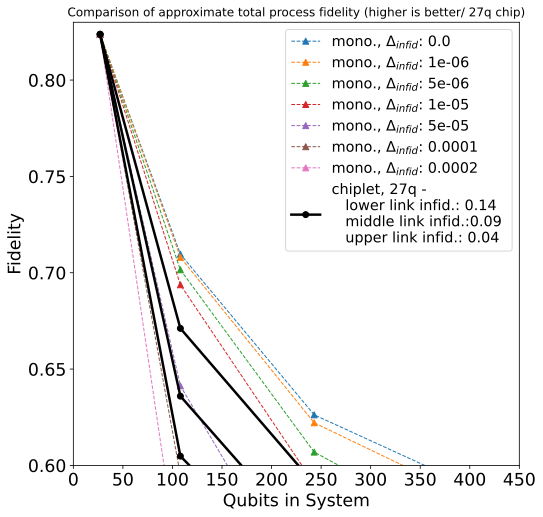

In [19]:

plt.figure(figsize=(8,8))

for i in range(len(rates_of_change)):
    plt.plot(sys_qbits,mono_fid[i], marker='^',linestyle='--',linewidth=1,label=r'mono., $\Delta_{infid}$: '+f'{rates_of_change[i]}')
plt.plot(sys_qbits,chip_fid[0],marker='o', linestyle='-',linewidth=2.5, color='k',label='chiplet, 27q -\n   lower link infid.: 0.14 \n   middle link infid.:0.09 \n   upper link infid.: 0.04 ')
plt.plot(sys_qbits,chip_fid[1],marker='o', linestyle='-',linewidth=2.5, color='k')
plt.plot(sys_qbits,chip_fid[2],marker='o', linestyle='-',linewidth=2.5, color='k')


plt.ylim(0.6,.83)
plt.xlim(0,450)

#plt.yscale('log')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title(f'Comparison of approximate total process fidelity (higher is better/ 27q chip)')
plt.ylabel('Fidelity',fontsize='xx-large')
plt.xlabel('Qubits in System',fontsize='xx-large')
plt.legend(fontsize='x-large')

plt.savefig('chip_991.pdf')
plt.show()

# ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** 


# Plot 2: F_{CX} Chip 0.9955 


In [21]:

dim_network = []
dim_mono = []
s_gap_network = []
s_gap_mono = []

sys_qbits = []



model_chip = Fake27QPulseV1()

product_r_chip_all = []
product_r_mono_all = []

chip_infid = 0.0045 # CHANGE ME
chip_r = (4/3)*chip_infid
one_minus_chip_r = 1-chip_r

def find_mono_infid(chip_infid,total_qubits,chip_qubits,rate_change):
    mono_infid = (total_qubits-chip_qubits)*rate_change + chip_infid
    return mono_infid


link_infid = [0.14, 0.09, 0.04]


rates_of_change = np.array([0,0.000001,0.000005,0.00001,0.00005,0.0001,0.0002])

for j in rates_of_change:
    product_r_mono_all.append([])
    
for j in link_infid:
    product_r_chip_all.append([])

for j in range(1,9):
    print(j)
    print('network')
    network_map, links = create_square_network_map_27f(model_chip,j)
    
    
    for k in range(len(link_infid)):
        
        link_r = 2*link_infid[k]
        one_minus_link_r = 1-link_r
   
        network_errors = {}
    
        for i in links:
            network_errors[str(i)] =  one_minus_link_r
    
        network_errors = create_full_error_dict_cpu(network_map,avg_error=(one_minus_chip_r**3),gate_errors=network_errors) # use average error for falcon good device i.e. kolkata/mumbai x3 for swap
        my_2x2_network = create_backend(network_map,'my_2x2_falcon_network',gate_errors=network_errors)
        print(f'total qubits: {my_2x2_network.configuration().n_qubits}')
        
        if k == 0:
            sys_qbits.append(my_2x2_network.configuration().n_qubits)
        
    
        my_2x2_network_graph = graph_from_machine(my_2x2_network.configuration().n_qubits,my_2x2_network.configuration().coupling_map)    
        print(f'chiplet diameter:{nx.diameter(my_2x2_network_graph)}')
        dim_network.append(nx.diameter(my_2x2_network_graph))
        
        laplac_s = nx.laplacian_spectrum(my_2x2_network_graph) #Returns eigenvalues of the Laplacian of G
        s_gap_network.append(laplac_s[-1]-laplac_s[-2])
    
        network_path = determine_diameter_path(my_2x2_network_graph)
        r_product_nw = 1
        for i in range(1,len(network_path)):
            r_product_nw = (my_2x2_network.properties().gate_error('cx',[network_path[i-1],network_path[i]])) * r_product_nw
        
        product_r_chip_all[k].append(r_product_nw)
        
        print(f'chiplet network diameter r product: {r_product_nw}')
        
   
    
    print('mono.')
    for k in range(len(rates_of_change)):
        mono_infid = find_mono_infid(chip_infid=chip_infid,total_qubits=sys_qbits[-1],
                                     chip_qubits=model_chip.configuration().n_qubits,
                                     rate_change=rates_of_change[k])
    
        mono_r = (4/3)*mono_infid
        one_minus_mono_r = 1-mono_r
        
        
        
        if j == 1:
            mono_dev_map = network_map
        else:
            mono_dev_map = create_monolithic_map_heavyhex(my_2x2_network.configuration().n_qubits)
        
        mono_errors = create_full_error_dict_cpu(mono_dev_map,avg_error=(one_minus_mono_r**3),gate_errors={}) #use error for best hummingbird i.e. brooklyn x3 for a swap operation
    
        monolithic_device = create_backend(mono_dev_map,'my_monolithic_device',gate_errors=mono_errors)
    
        mono_graph = graph_from_machine(monolithic_device.configuration().n_qubits,monolithic_device.configuration().coupling_map)
        print(f'monolithic diameter:{nx.diameter(mono_graph)}')
        dim_mono.append(nx.diameter(mono_graph))
        
        laplac_s = nx.laplacian_spectrum(mono_graph) #Returns eigenvalues of the Laplacian of G
        s_gap_mono.append(laplac_s[-1]-laplac_s[-2])
    
        r_product_mono = 1
        mono_path = determine_diameter_path(mono_graph)
        for i in range(1,len(mono_path)):
            r_product_mono = (monolithic_device.properties().gate_error('cx',[mono_path[i-1],mono_path[i]])) * r_product_mono
        
        print(f'monolithic diameter r product: {r_product_mono}')
        product_r_mono_all[k].append(r_product_mono)
        print()

1
network
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.8052112579794675
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.8052112579794675
total qubits: 27
chiplet diameter:12
chiplet network diameter r product: 0.8052112579794675
mono.
monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675

2
network
total qubits: 108
chiplet diameter:27
chiplet network diameter r product: 0.3300987065920682
total qubits: 108
chiplet diameter:27
chiplet network diameter r product: 0.42816043655

In [22]:
chip_fid = []
for item in product_r_chip_all:
    chip_fid.append([])
    for i in item:
        temp = 1-i
        temp_fid = 1-temp/2
        chip_fid[-1].append(temp_fid)

mono_fid = []

for item in product_r_mono_all:
    mono_fid.append([])
    for i in item:
        temp = 1-i
        temp_fid = 1-temp/2
        #print(temp_fid)
        mono_fid[-1].append(temp_fid)

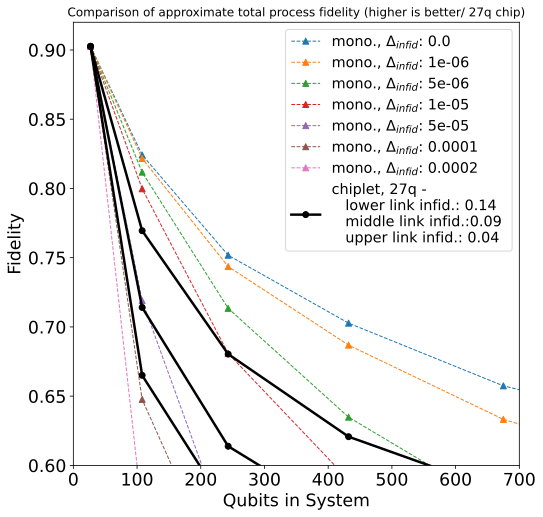

In [24]:

plt.figure(figsize=(8,8))

for i in range(len(rates_of_change)):
    plt.plot(sys_qbits,mono_fid[i], marker='^',linestyle='--',linewidth=1,label=r'mono., $\Delta_{infid}$: '+f'{rates_of_change[i]}')
plt.plot(sys_qbits,chip_fid[0],marker='o', linestyle='-',linewidth=2.5, color='k',label='chiplet, 27q -\n   lower link infid.: 0.14 \n   middle link infid.:0.09 \n   upper link infid.: 0.04 ')
plt.plot(sys_qbits,chip_fid[1],marker='o', linestyle='-',linewidth=2.5, color='k')
plt.plot(sys_qbits,chip_fid[2],marker='o', linestyle='-',linewidth=2.5, color='k')


plt.ylim(0.6,.92)
plt.xlim(0,700)


plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title(f'Comparison of approximate total process fidelity (higher is better/ 27q chip)')
plt.ylabel('Fidelity',fontsize='xx-large')
plt.xlabel('Qubits in System',fontsize='xx-large')
plt.legend(fontsize='x-large')

plt.savefig('chip_9955.pdf')   
plt.show()


# ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** 
# Link fidelity vs qubits/ 27-q chip (chip fid 0.9955) 

In [25]:
dim_network = []
dim_mono = []
sys_qbits = []

needed_link_fid = []


model_chip = model_chip

chip_infid = 0.0045

chip_r = (4/3)*chip_infid
one_minus_chip_r = 1-chip_r

def find_mono_infid(chip_infid,total_qubits,chip_qubits,rate_change):
    mono_infid = (total_qubits-chip_qubits)*rate_change + chip_infid
    return mono_infid


link_infid = []


rates_of_change = [0.000001,0.000005,0.00001,0.00005,0.0001,0.0002]
for i in rates_of_change:
    link_infid.append([])


for j in range(1,13):
    print(j)
    print('network')
    network_map, links = create_square_network_map_27f(model_chip,j)

    network_errors = {}
    
    for i in links:
        network_errors[str(i)] =  -1 #one_minus_link_r
    
    network_errors = create_full_error_dict_cpu(network_map,avg_error=(one_minus_chip_r**3),gate_errors=network_errors) # use average error for falcon good device i.e. kolkata/mumbai x3 for swap
    my_2x2_network = create_backend(network_map,'my_2x2_falcon_network',gate_errors=network_errors)
    print(f'total qubits: {my_2x2_network.configuration().n_qubits}')
        

    sys_qbits.append(my_2x2_network.configuration().n_qubits)
        
    
    print('mono.')
    for k in range(len(rates_of_change)):
        
        mono_infid = find_mono_infid(chip_infid=chip_infid,total_qubits=sys_qbits[-1],
                                     chip_qubits=model_chip.configuration().n_qubits,
                                     rate_change=rates_of_change[k])
    
        mono_r = (4/3)*mono_infid
        one_minus_mono_r = 1-mono_r
        
        
        
        mono_dev_map = create_monolithic_map_heavyhex(my_2x2_network.configuration().n_qubits)
        mono_errors = create_full_error_dict_cpu(mono_dev_map,avg_error=(one_minus_mono_r**3),gate_errors={}) #use error for best hummingbird i.e. brooklyn x3 for a swap operation
    
        monolithic_device = create_backend(mono_dev_map,'my_monolithic_device',gate_errors=mono_errors)
    
        mono_graph = graph_from_machine(monolithic_device.configuration().n_qubits,monolithic_device.configuration().coupling_map)
        print(f'monolithic diameter:{nx.diameter(mono_graph)}')
        dim_mono.append(nx.diameter(mono_graph))
    
        r_product_mono = 1
        mono_path = determine_diameter_path(mono_graph)
        for i in range(1,len(mono_path)):
            r_product_mono = (monolithic_device.properties().gate_error('cx',[mono_path[i-1],mono_path[i]])) * r_product_mono
        
        print(f'monolithic diameter r product: {r_product_mono}')
        product_r_mono_all[k].append(r_product_mono)
        
        temp = 1-r_product_mono
        mono_fid = 1-temp/2
        print(f'monolithic process fid: {mono_fid}')
        
        r_prod_chip_all = 1-2*(1-mono_fid)
        print(f'r prod. chip. all: {r_prod_chip_all}')
        print()
        
        my_2x2_network_graph = graph_from_machine(my_2x2_network.configuration().n_qubits,my_2x2_network.configuration().coupling_map)    
        print(f'chiplet diameter:{nx.diameter(my_2x2_network_graph)}')
        dim_network.append(nx.diameter(my_2x2_network_graph))
    
        network_path = determine_diameter_path(my_2x2_network_graph)
        
        r_product_nw_on_chip = 1
        count_links = 0
        
        for i in range(1,len(network_path)):
            if my_2x2_network.properties().gate_error('cx',[network_path[i-1],network_path[i]]) == -1:
                count_links = count_links +1
            else:
                r_product_nw_on_chip = (my_2x2_network.properties().gate_error('cx',[network_path[i-1],network_path[i]])) * r_product_nw_on_chip
        
        
        print(f'chiplet network diameter r product (on chip): {r_product_nw_on_chip}')
        
        r_prod_links = r_prod_chip_all/r_product_nw_on_chip
        print(f'r-prod-links: {r_prod_links}')
        
        print(f'count links: {count_links}')
        if count_links !=0:
            one_minus_r_link = np.power(r_prod_links,1/count_links)
        else:
            one_minus_r_link = r_prod_links
        
        print(one_minus_r_link)
        link_r = 1 - one_minus_r_link
        
        infid_link = (1/2)*(link_r)
        link_infid[k].append(infid_link)
        print(f'infid. link: {infid_link}')
        print()
        
        

1
network
total qubits: 27
mono.
monolithic diameter:12
monolithic diameter r product: 0.8052112579794675
monolithic process fid: 0.9026056289897337
r prod. chip. all: 0.8052112579794675

chiplet diameter:12
chiplet network diameter r product (on chip): 0.8052112579794675
r-prod-links: 1.0
count links: 0
1.0
infid. link: 0.0

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675
monolithic process fid: 0.9026056289897337
r prod. chip. all: 0.8052112579794675

chiplet diameter:12
chiplet network diameter r product (on chip): 0.8052112579794675
r-prod-links: 1.0
count links: 0
1.0
infid. link: 0.0

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675
monolithic process fid: 0.9026056289897337
r prod. chip. all: 0.8052112579794675

chiplet diameter:12
chiplet network diameter r product (on chip): 0.8052112579794675
r-prod-links: 1.0
count links: 0
1.0
infid. link: 0.0

monolithic diameter:12
monolithic diameter r product: 0.8052112579794675
monolithi

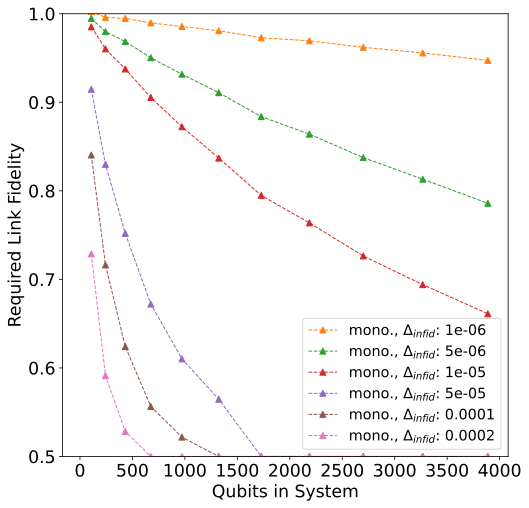

In [26]:
plt.figure(figsize=(8,8))
plt.plot(sys_qbits[:2],[0.3,0.3])
for i in range(len(rates_of_change)):
    temp_req_fid = [1 - x for x in link_infid[i]]
    plt.plot(sys_qbits[1:],temp_req_fid[1:], marker='^',linestyle='--',linewidth=1,label=r'mono., $\Delta_{infid}$: '+f'{rates_of_change[i]}')



plt.ylim(0.5,1)
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Required Link Fidelity',fontsize='xx-large')
plt.xlabel('Qubits in System',fontsize='xx-large')
plt.legend(fontsize='x-large')


plt.savefig('link_9955.pdf')
plt.show()

# ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** 
## Graph Diameter and Spectral Gap Analysis 

In [27]:
"""
Code to load in Falcon & other processors
"""
from networkfuncs import *


falcon_backend_default = Fake27QPulseV1()
falcon_coupling_map = falcon_backend_default.configuration().coupling_map

print("Falcon Coupling Map")
print(falcon_coupling_map)

falcon_joiner_points = [6,17,9,20,0,26]

falcon_chip_size = 27

"""
eagle_default_backend = FakeWashington()

eagle_coupling_map = eagle_default_backend.configuration().coupling_map
"""



#Done

Falcon Coupling Map
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


'\neagle_default_backend = FakeWashington()\n\neagle_coupling_map = eagle_default_backend.configuration().coupling_map\n'

In [28]:
"""
Here we directly analyze random graphs

"""
from networkfuncs import *

import networkx as nx

chip_numbers = range(24, 96, 6)

results = []

for chip_num in chip_numbers:
    best_g_unchipped, best_lambda2_unchipped = best_random_expander(chip_num*falcon_chip_size, 3, 200)
    print("Evaluated chip number %d" % chip_num)
    diam_unchipped = nx.algorithms.distance_measures.diameter(best_g_unchipped)
    best_g, best_lambda2 = best_random_expander_chipped(chip_num, 1200, 80,
                                            falcon_coupling_map, falcon_joiner_points)
    diam = nx.algorithms.distance_measures.diameter(best_g)
    results.append([best_g, best_lambda2, diam,
                    best_g_unchipped, best_lambda2_unchipped, diam_unchipped])

#Done

Evaluated chip number 24
Evaluated chip number 30
Evaluated chip number 36
Evaluated chip number 42
Evaluated chip number 48
Evaluated chip number 54
Evaluated chip number 60
Evaluated chip number 66
Evaluated chip number 72
Evaluated chip number 78
Evaluated chip number 84
Evaluated chip number 90


In [29]:
for chip_num, (best_g, best_lambda2, diam,
               best_g_unchipped, best_lambda2_unchipped, diam_unchipped) in zip(chip_numbers, results):
    #print([best_gap, chip_num])
    print("Spectral gap %f, diam %d at chip # %d / qubit # %d" % (
        best_lambda2, diam, chip_num, chip_num*falcon_chip_size))
    print("Spectral gap %f, diam %d for free qubits" % (
        best_lambda2_unchipped, diam_unchipped))
    print()
    
print([[item[1], item[2], item[4], item[5]] for item in results])

Spectral gap 0.009540, diam 29 at chip # 24 / qubit # 648
Spectral gap 0.066715, diam 12 for free qubits

Spectral gap 0.008333, diam 29 at chip # 30 / qubit # 810
Spectral gap 0.066162, diam 12 for free qubits

Spectral gap 0.007681, diam 31 at chip # 36 / qubit # 972
Spectral gap 0.064745, diam 13 for free qubits

Spectral gap 0.007084, diam 34 at chip # 42 / qubit # 1134
Spectral gap 0.063424, diam 13 for free qubits

Spectral gap 0.006824, diam 33 at chip # 48 / qubit # 1296
Spectral gap 0.063308, diam 13 for free qubits

Spectral gap 0.006593, diam 34 at chip # 54 / qubit # 1458
Spectral gap 0.062096, diam 13 for free qubits

Spectral gap 0.006608, diam 35 at chip # 60 / qubit # 1620
Spectral gap 0.062307, diam 13 for free qubits

Spectral gap 0.006296, diam 35 at chip # 66 / qubit # 1782
Spectral gap 0.061965, diam 14 for free qubits

Spectral gap 0.006077, diam 37 at chip # 72 / qubit # 1944
Spectral gap 0.061388, diam 14 for free qubits

Spectral gap 0.005871, diam 37 at chip #

In [30]:
"""
Try chordal graphs

networkx.generators.expanders.chordal_cycle_graph

"""
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53,
          59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113,
          127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191,
          193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271]

falcon_joiner_points = [6,17,0,26,9,20]

chordal_cycle_info = []    

for p in primes[:20]:
    g = nx.generators.expanders.chordal_cycle_graph(p)
    chip_g = put_chips_locally_in_graph(g, falcon_coupling_map, falcon_joiner_points, 27)
    lspec = np.sort(nx.laplacian_spectrum(chip_g))
    gap = lspec[-1] - lspec[-2]
    diam = nx.algorithms.distance_measures.diameter(chip_g)
    print("Chordal cycle graph with %d chips" % p)
    print("Spectral gap %f" % gap)
    print("Diameter %d" % diam)
    chordal_cycle_info.append((p, gap, diam))
    print()
    
#Done
print("Done")

Chordal cycle graph with 2 chips
Spectral gap 0.056625
Diameter 14

Chordal cycle graph with 3 chips
Spectral gap 0.014458
Diameter 17

Chordal cycle graph with 5 chips
Spectral gap 0.014969
Diameter 22

Chordal cycle graph with 7 chips
Spectral gap 0.014879
Diameter 27

Chordal cycle graph with 11 chips
Spectral gap 0.005437
Diameter 35

Chordal cycle graph with 13 chips
Spectral gap 0.001426
Diameter 37

Chordal cycle graph with 17 chips
Spectral gap 0.003313
Diameter 40

Chordal cycle graph with 19 chips
Spectral gap 0.004274
Diameter 40

Chordal cycle graph with 23 chips
Spectral gap 0.000868
Diameter 48

Chordal cycle graph with 29 chips
Spectral gap 0.002640
Diameter 47

Chordal cycle graph with 31 chips
Spectral gap 0.002576
Diameter 48

Chordal cycle graph with 37 chips
Spectral gap 0.001407
Diameter 51

Chordal cycle graph with 41 chips
Spectral gap 0.001921
Diameter 53

Chordal cycle graph with 43 chips
Spectral gap 0.002555
Diameter 52

Chordal cycle graph with 47 chips
Spec

In [31]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

heavyhex_final = create_heavy_hex_chiplet(4, 2)

rows, joiners, r_coup, j_coup, h_links, v_links, lcr, lcj = heavyhex_final

print("Row qubits %d" % len(rows))
print('\n'.join(str(item) + ' ' + str(len(item)) for item in rows))
print()
print("Row connections %d" % len(r_coup))
print('\n'.join(str(item) + ' ' + str(len(item)) for item in r_coup))
print()
print("Joiner qubits %d" % len(joiners))
print('\n'.join(str(item) + ' ' + str(len(item)) for item in joiners))
print()
print("Joiner connections %d" % len(j_coup))
print('\n'.join(str(item) + ' ' + str(len(item)) for item in j_coup))
print()
print("Dimensions")
sorted_inds = sorted(list(deep_flatten(rows)) + list(deep_flatten(joiners)))
print(len(sorted_inds))
all_qubits = set(deep_flatten(rows)) | set(deep_flatten(joiners))
print(len(all_qubits))
expected_num = len(set(deep_flatten(rows))) | len(set(deep_flatten(joiners)))
print(expected_num)
print("Width %d and height %d" % (len(rows[0]), 4*len(rows)))
print()
print("Right links out")
print(h_links)
print(len(h_links))
print()
print("Down links out")
print(v_links)
print(len(v_links))
print()
print("Row links used")
print(lcr)
print()
print("Down links used")
print(lcj)
print()

couplings = hex_chip_to_coupling_map(heavyhex_final)
print("Coupling map has %d qubits" % len(set(deep_flatten(couplings))))
g = graph_from_couplings(couplings)
source, targ, path, diam = find_worst_path(g)
#print(nx.algorithms.components.is_connected(g))
print(len(g))
print("Worst path %s with diam %f" % (str(path), diam))
print(graph_lambda2(g))
print()
if not nx.algorithms.components.is_connected(g):
    print("Graph is disconnected")
    components = list(nx.algorithms.components.connected_components(g))
    print('\n'.join(str(item) for item in components))
    print([len(s) for s in components])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Row qubits 4
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15) 16
(20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35) 16
(40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55) 16
(60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75) 16

Row connections 4
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15)] 15
[(20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35)] 15
[(40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55)] 15
[(60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75)] 15

Joiner qubits 4
(16,

In [32]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings, links = create_square_network_map_27f(2)
print(couplings)
print()
print(links)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25], [27, 28], [28, 27], [28, 29], [28, 31], [29, 28], [29, 30], [30, 29], [30, 32], [31, 28], [31, 34], [32, 30], [32, 35], [33, 34], [34, 31], [34, 33], [34, 37], [35, 32], [35, 36], [35, 38], [36, 35], [37, 34], [37, 39], [38, 35], [38, 41], [39, 37], [39, 40], [39, 42], [40, 39], [40, 41], [41, 38], [41, 40], [41, 43], [42, 39], [42, 45], [43, 41], [43, 46], [44, 45], [45, 42], [45, 44], [

In [33]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings, links = create_oct_grid(2,1)
print(couplings)
print()
print(links)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 0], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 8], [2, 15], [3, 14]]

[[2, 15], [3, 14]]


In [34]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings, links = create_hex_connects_oct_2(1,2)
print(couplings)
print()
print(links)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 0], [8, 9], [9, 8], [9, 10], [9, 12], [10, 9], [10, 11], [11, 10], [11, 13], [12, 9], [12, 15], [13, 11], [13, 16], [14, 15], [15, 12], [15, 14], [15, 18], [16, 13], [16, 17], [16, 19], [17, 16], [18, 15], [18, 20], [19, 16], [19, 22], [20, 18], [20, 21], [20, 23], [21, 20], [21, 22], [22, 19], [22, 21], [22, 24], [23, 20], [23, 26], [24, 22], [24, 27], [25, 26], [26, 23], [26, 25], [26, 29], [27, 24], [27, 28], [27, 30], [28, 27], [29, 26], [29, 31], [30, 27], [30, 33], [31, 29], [31, 32], [32, 31], [32, 33], [33, 30], [33, 32], [33, 34], [34, 33], [35, 36], [36, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 42], [42, 35], [43, 44], [44, 43], [44, 45], [44, 47], [45, 44], [45, 46], [46, 45], [46, 48], [47, 44], [47, 50], [48, 46], [48, 51], [49, 50], [50, 47], [50, 49], [50, 53], [51, 48], [51, 52], [51, 54], [52, 51], [53, 50], [53, 

In [35]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings, links = create_hex_connects_square(2,1)
print(couplings)
print()
print(links)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1], [1, 2], [2, 3], [3, 0], [0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 4], [5, 6], [5, 8], [6, 5], [6, 7], [7, 6], [7, 9], [8, 5], [8, 11], [9, 7], [9, 12], [10, 11], [11, 8], [11, 10], [11, 14], [12, 9], [12, 13], [12, 15], [13, 12], [14, 11], [14, 16], [15, 12], [15, 18], [16, 14], [16, 17], [16, 19], [17, 16], [17, 18], [18, 15], [18, 17], [18, 20], [19, 16], [19, 22], [20, 18], [20, 23], [21, 22], [22, 19], [22, 21], [22, 25], [23, 20], [23, 24], [23, 26], [24, 23], [25, 22], [25, 27], [26, 23], [26, 29], [27, 25], [27, 28], [28, 27], [28, 29], [29, 26], [29, 28], [29, 30], [30, 29], [31, 32], [32, 33], [33, 34], [34, 31], [31, 32], [32, 33], [33, 34], [34, 31], [35, 36], [36, 35], [36, 37], [36, 39], [37, 36], [37, 38], [38, 37], [38, 40], [39, 36], [39, 42], [40, 38], [40, 43], [41, 42], [42, 39], [42, 41], [42, 45], [43, 40], [43, 44], [43, 46], [44, 43], [45, 42], [45, 47], [46, 43], [

In [36]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings_grid = grids_q(3, 2, 0.5, 0.4)
print('\n'.join(str(item) for item in couplings_grid[0]))
print()
print(couplings_grid[1])

print(make_bidir(couplings_grid[1]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1, 0.5], [1, 2, 0.5], [0, 3, 0.5], [1, 4, 0.5], [3, 4, 0.5], [2, 5, 0.5], [4, 5, 0.5], [3, 6, 0.5], [4, 7, 0.5], [6, 7, 0.5], [5, 8, 0.5], [7, 8, 0.5]]
[[9, 10, 0.5], [10, 11, 0.5], [9, 12, 0.5], [10, 13, 0.5], [12, 13, 0.5], [11, 14, 0.5], [13, 14, 0.5], [12, 15, 0.5], [13, 16, 0.5], [15, 16, 0.5], [14, 17, 0.5], [16, 17, 0.5]]
[[18, 19, 0.5], [19, 20, 0.5], [18, 21, 0.5], [19, 22, 0.5], [21, 22, 0.5], [20, 23, 0.5], [22, 23, 0.5], [21, 24, 0.5], [22, 25, 0.5], [24, 25, 0.5], [23, 26, 0.5], [25, 26, 0.5]]
[[27, 28, 0.5], [28, 29, 0.5], [27, 30, 0.5], [28, 31, 0.5], [30, 31, 0.5], [29, 32, 0.5], [31, 32, 0.5], [30, 33, 0.5], [31, 34, 0.5], [33, 34, 0.5], [32, 35, 0.5], [34, 35, 0.5]]

[[12, 5, 0.4], [19, 7, 0.4], [28, 16, 0.4], [30, 23, 0.4]]
{(30, 23, 0.4), (23, 30, 0.4), (7, 19, 0.4), (5, 12, 0.4), (16, 28, 0.4), (28, 16, 0.4), (12, 5, 0.4), (19, 7, 0.4)}


In [37]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

couplings_tree = tree_of_grids(3, 3, 0.1, 0.4)
print('\n\n'.join('\n'.join(str(item) for item in layer) for layer in couplings_tree[0]))
print()
print()
print("Up-down connections")
print(couplings_tree[1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[[[0, 1], [1, 2], [0, 3], [1, 4], [3, 4], [2, 5], [4, 5], [3, 6], [4, 7], [6, 7], [5, 8], [7, 8]]], [[[9, 10], [10, 11], [9, 12], [10, 13], [12, 13], [11, 14], [13, 14], [12, 15], [13, 16], [15, 16], [14, 17], [16, 17]], [[18, 19], [19, 20], [18, 21], [19, 22], [21, 22], [20, 23], [22, 23], [21, 24], [22, 25], [24, 25], [23, 26], [25, 26]]], [[[27, 28], [28, 29], [27, 30], [28, 31], [30, 31], [29, 32], [31, 32], [30, 33], [31, 34], [33, 34], [32, 35], [34, 35]], [[36, 37], [37, 38], [36, 39], [37, 40], [39, 40], [38, 41], [40, 41], [39, 42], [40, 43], [42, 43], [41, 44], [43, 44]], [[45, 46], [46, 47], [45, 48], [46, 49], [48, 49], [47, 50], [49, 50], [48, 51], [49, 52], [51, 52], [50, 53], [52, 53]], [[54, 55], [55, 56], [54, 57], [55, 58], [57, 58], [56, 59], [58, 59], [57, 60], [58, 61], [60, 61], [59, 62], [61, 62]]]]
[[0, 1, 0.1], [1, 2, 0.1], [0, 3, 0.1], [1, 4, 0.1], [3, 4, 0.1], [2, 5, 0.1]

In [38]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

import multiprocessing

def metrics_func(names, local_weight, link_weight):
    pass

def subprocess_metrics(names, local_weight, link_weight):
    q = multiprocessing.Queue()
    p = multiprocessing.Process(target=metrics_func, args=(q,local_weight,link_weight))


weighted = False
metrics_results = None

if not weighted:
    metrics_results = process_graphs(
        generate_graphs([#["Octagons"]))
            "Mono Hex", "Mono Grid", "Chiplet Grid", "Tree of Grids",
            "27q Chiplet", "80q Hex Chiplet",
            "Octagons","Hex-Octagon",
            "Hex-Square",
            "Expander"]))
else:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mono Hex
Qubit Number 675, Diameter 64.000000, Lambda2 0.001191 
Qubit Number 972, Diameter 77.000000, Lambda2 0.000866 
Qubit Number 1323, Diameter 90.000000, Lambda2 0.000555 
Qubit Number 1728, Diameter 106.000000, Lambda2 0.000445 
Qubit Number 2187, Diameter 116.000000, Lambda2 0.000362 
Qubit Number 2700, Diameter 130.000000, Lambda2 0.000269 

Mono Grid
Qubit Number 625, Diameter 48.000000, Lambda2 0.004191 
Qubit Number 900, Diameter 58.000000, Lambda2 0.002882 
Qubit Number 1225, Diameter 68.000000, Lambda2 0.002102 
Qubit Number 1600, Diameter 78.000000, Lambda2 0.001601 
Qubit Number 2025, Diameter 88.000000, Lambda2 0.001260 
Qubit Number 2500, Diameter 98.000000, Lambda2 0.001017 

Chiplet Grid
Qubit Number 625, Diameter 48.000000, Lambda2 0.001991 
Qubit Number 900, Diameter 58.000000, Lambda2 0.001385 
Qubit Number 1225, Diameter 68.000000, Lambda2 0.001018 
Qubit Number 1600, Diamete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


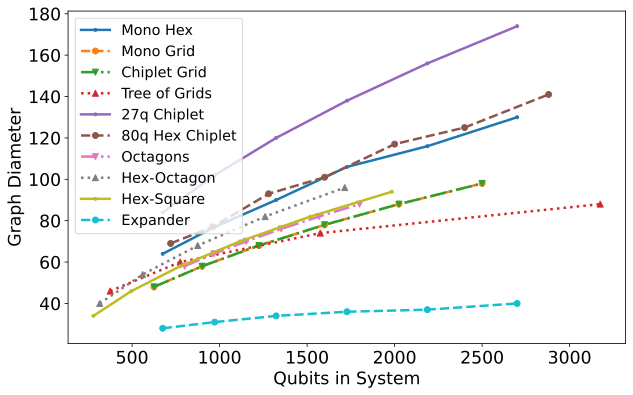

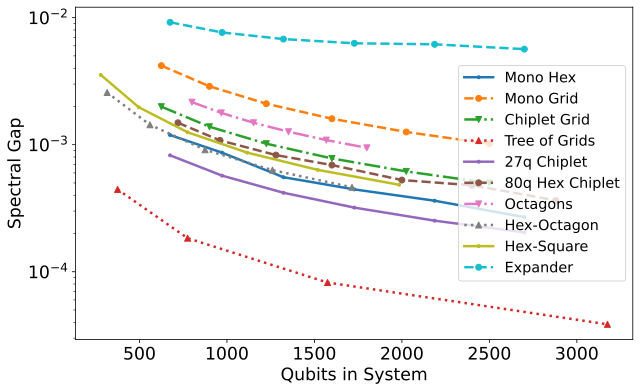

In [42]:
%load_ext autoreload
%autoreload 2

from networkfuncs import *
from util import *

import numpy as np


results_to_use = metrics_results

diameters_by_qubit_num = [(name, [(qubit_num, path_info[-1]) for qubit_num, path_info, lambda2 in l])
                          for name, l in results_to_use]
lambda2s_by_qubit_num = [(name, [(qubit_num, lambda2) for qubit_num, path_info, lambda2 in l])
                          for name, l in results_to_use]

plot_graph_value(diameters_by_qubit_num, 'Graph Diameter')
plt.savefig('diameter.pdf')
plot_graph_value(lambda2s_by_qubit_num, 'Spectral Gap')
plt.yscale("log")
plt.savefig('spectralgap.pdf')

In [43]:
import sys

for module in sys.modules.values():
    if hasattr(module, "__version__"):
        print(module.__name__, module.__version__)
    else:
        print(module.__name__)

sys
builtins
importlib._bootstrap
_imp
_thread
_warnings
_weakref
io
marshal
posix
importlib._bootstrap_external
time
zipimport
_codecs
codecs
encodings.aliases
encodings
encodings.utf_8
_signal
_abc
abc
io
__main__
_stat
stat
collections.abc
genericpath
posixpath
posixpath
os
_sitebuiltins
_distutils_hack
site
importlib._bootstrap
importlib._bootstrap_external
warnings
importlib
importlib.machinery
importlib._abc
itertools
keyword
_operator
operator
reprlib
_collections
collections
types
_functools
functools
contextlib
importlib.util
runpy
enum
_sre
re._constants
re._parser
re._casefix
re._compiler
copyreg
re 2.2.1
fnmatch
ntpath
errno
urllib
urllib.parse
pathlib
collections.abc
_typing
typing.io
typing.re
typing
ipykernel._version 6.29.4
__future__
_json
json.scanner
json.decoder
json.encoder
json 2.0.9
_locale
locale
signal
_weakrefset
threading
fcntl
_posixsubprocess
select
math
selectors
subprocess
jupyter_client._version 8.6.2
platform 1.0.8
zmq.backend.select
cython_runtime
_cyt